In [12]:
!pip install tqdm scipy numpy jax h5py

Code adapted from: https://github.com/zzhangzzhang/pLMs-interpretability/tree/main

In [3]:
import time
import os 
import torch 
import json 
from tqdm import tqdm 
import numpy as np
from scipy.special import softmax
from utils import *
import random 
import matplotlib.pyplot as plt

In [3]:
pid = "3LAEA"
sequence = "SNAIQQSDGSMIIDGSANLRDLNKMFNWELDTEDARTFNGLILEHLEEIPDEGTICEIDGLLITILEVGDNMIKQAKVVKL"
print(len(sequence))

81


In [4]:
# LOAD MODEL AND PUT TO GPU
model, alphabet = torch.hub.load("facebookresearch/esm:main", "esm2_t6_8M_UR50D")
# put model on GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
model = model.to(device)
model = model.eval()
#model.args.token_dropout = False

Using cache found in /root/.cache/torch/hub/facebookresearch_esm_main


In [5]:
def get_categorical_jacobian(seq):
  # ∂in/∂out
  x,ln = alphabet.get_batch_converter()([("seq",seq)])[-1],len(seq)
  with torch.no_grad():
    f = lambda x: model(x)["logits"][...,1:(ln+1),4:24].cpu().numpy()
    fx = f(x.to(device))[0]
    x = torch.tile(x,[20,1]).to(device)
    fx_h = np.zeros((ln,20,ln,20))
    for n in range(ln): # for each position
      x_h = torch.clone(x)
      x_h[:,n+1] = torch.arange(4,24) # mutate to all 20 aa
      fx_h[n] = f(x_h)
    return fx_h - fx
def get_contacts(x, symm=True, center=True, rm=1):
  # convert jacobian (L,A,L,A) to contact map (L,L)
  j = x.copy()
  if center:
    for i in range(4): j -= j.mean(i,keepdims=True)
  j_fn = np.sqrt(np.square(j).sum((1,3)))
  np.fill_diagonal(j_fn,0)
  j_fn_corrected = do_apc(j_fn, rm=rm)
  if symm:
    j_fn_corrected = (j_fn_corrected + j_fn_corrected.T)/2
  return j_fn_corrected
def do_apc(x, rm=1):
  '''given matrix do apc correction'''
  # trying to remove different number of components
  # rm=0 remove none
  # rm=1 apc
  x = np.copy(x)
  if rm == 0:
    return x
  elif rm == 1:
    a1 = x.sum(0,keepdims=True)
    a2 = x.sum(1,keepdims=True)
    y = x - (a1*a2)/x.sum()
  else:
    # decompose matrix, rm largest(s) eigenvectors
    u,s,v = np.linalg.svd(x)
    y = s[rm:] * u[:,rm:] @ v[rm:,:]
  np.fill_diagonal(y,0)
  return y

In [6]:
# calculate Categorical Jacobian Matrix for example sequence
cjm1 = get_categorical_jacobian(sequence)
print(cjm1.shape)

(81, 20, 81, 20)


In [16]:
print(cjm1)

[[[[ 3.41732457e+00 -4.78416681e-03  2.69852981e-01 ... -1.03670597e-01
     2.86018848e-01  5.30680656e-01]
   [-5.45552060e-01 -3.65303889e-01 -4.15263355e-01 ...  5.66026688e-01
    -4.36319828e-01 -4.23448086e-01]
   [-1.85286999e-03  2.56918907e-01  8.95934105e-02 ... -1.48481607e-01
    -2.03598976e-01  3.59705806e-01]
   ...
   [ 3.76935005e-02 -2.07155943e-03 -4.70769405e-03 ... -1.93699598e-02
    -4.26415205e-02  2.66134739e-03]
   [-8.17269087e-04  1.99301541e-02  1.78694427e-02 ...  1.99298859e-02
    -4.39968109e-02 -1.18947029e-02]
   [ 9.40585136e-03 -4.98116016e-04 -5.83149493e-03 ... -6.19626045e-03
    -1.82125568e-02 -2.40285397e-02]]

  [[ 5.65644130e-02  2.94582582e+00  2.92147115e-01 ... -4.52260971e-02
     7.72705078e-02  1.74675703e-01]
   [-3.02699149e-01 -3.71168897e-01 -3.43893528e-01 ...  3.38351965e-01
    -2.10889816e-01 -3.12036395e-01]
   [ 1.34314358e-01  2.13923931e-01  3.17407846e-02 ... -2.46654868e-01
    -1.60076618e-01  2.27752686e-01]
   ...
   

In [8]:
cjm1 = cjm1
np.save('cjm1.npy', cjm1)

In [17]:
# Calculate Contact Map from CJM
contact_map = get_contacts(cjm1)
print(contact_map.shape)

(81, 81)


In [18]:
contact_map

array([[ 0.        ,  4.18712806,  1.74236032, ..., -0.24028001,
        -0.1745169 , -0.06891539],
       [ 4.18712806,  0.        ,  4.56324376, ..., -0.29906757,
        -0.19586184, -0.18845573],
       [ 1.74236032,  4.56324376,  0.        , ..., -0.26162938,
        -0.20698234, -0.16587054],
       ...,
       [-0.24028001, -0.29906757, -0.26162938, ...,  0.        ,
         2.51242252,  1.2608978 ],
       [-0.1745169 , -0.19586184, -0.20698234, ...,  2.51242252,
         0.        ,  2.71911655],
       [-0.06891539, -0.18845573, -0.16587054, ...,  1.2608978 ,
         2.71911655,  0.        ]])

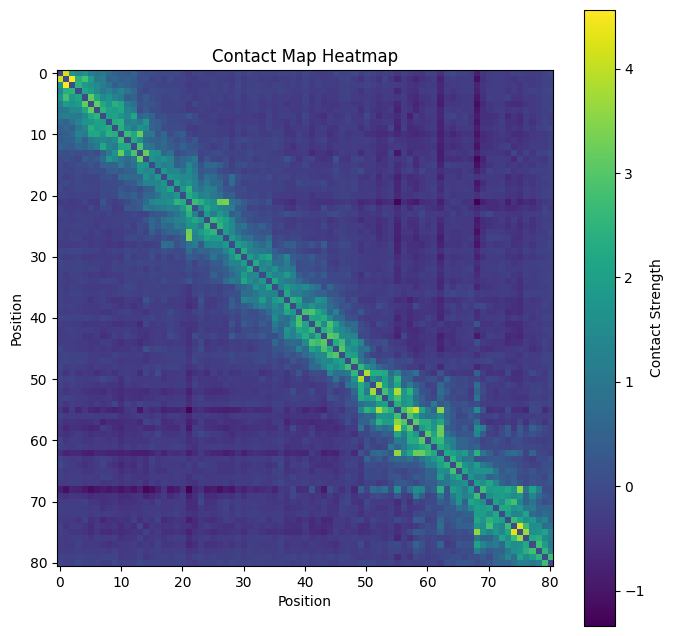

In [19]:
# Plot contact map
# Make the heatmap plot
plt.figure(figsize=(8, 8))
plt.imshow(contact_map, cmap="viridis", interpolation="nearest")
plt.colorbar(label="Contact Strength")
plt.title("Contact Map Heatmap")
plt.xlabel("Position")
plt.ylabel("Position")
plt.show()

In [ ]:
apc_contact_map = 

### Calculate seconds/1000 tokens for calculating it

In [6]:
# Load JSON data from a file into a dictionary
with open('/notebooks/pLMs-interpretability/data/full_seq_dict.json', 'r') as file:
    all_seqs = json.load(file)
print("First 5 keys:", list(all_seqs.keys())[:5])
print("First 5 sequences:", list(all_seqs.values())[:5])
print("Total dict_length:", len(all_seqs.keys()))

First 5 keys: ['2GWGA', '3LAEA', '4MC3A', '1TX4A', '3NHEA']
First 5 sequences: ['MIIDIHGHYTTAPKALEDWRNRQIAGIKDPSVMPKVSELKISDDELQASIIENQLKKMQERGSDLTVFSPRASFMAHHIGDFNVSSTWAAICNELCYRVSQLFPDNFIGAAMLPQSPGVDPKTCIPELEKCVKEYGFVAINLNPDPSGGHWTSPPLTDRIWYPIYEKMVELEIPAMIHVSTSCNTCFHTTGAHYLNADTTAFMQCVAGDLFKDFPELKFVIPHGGGAVPYHWGRFRGLAQEMKKPLLEDHVLNNIFFDTCVYHQPGIDLLNTVIPVDNVLFASEMIGAVRGIDPRTGFYYDDTKRYIEASTILTPEEKQQIYEGNARRVYPRLDAALKAKGKLEHHHHHH', 'SNAIQQSDGSMIIDGSANLRDLNKMFNWELDTEDARTFNGLILEHLEEIPDEGTICEIDGLLITILEVGDNMIKQAKVVKL', 'MAEFEIPDFYVPFPLECNPHLEEASRAMWEWIDANGLAPTERARDRMRRTGADLSGAYVWPRADLDTLTIGLKWIALTFRIDDQIDEDDTAERLPARMTAIDELRGTLHGLPVSGRSPTARALGALWQETALGRPATWCDAFIGHFEAFLQTYTTEAGLNAHGAGLRLDDYLDRRMYSVGMPWLWDLDELRLPIFLPGSVRTCGPMNKLRRAGALHIALVNDVFSVERETLVGYQHNAVTIIREAQGCSLQEAVDQVAVLVEAQLHTVLQARQELLEELDRQALPSRAREAAVDYAANVAANLSGQLVWHSSVERYAVDDLQSAADPRATPTTSSLGILEHHHHHH', 'RPPLPNQQFGVSLQHLQEKNPEQEPIPIVLRETVAYLQAHALTTEGIFRRSANTQVVREVQQKYNMGLPVDFDQYNALHLPAVILKTFLRELPEPLLTFDLYPHVVGFLNIDESQRVPATLQVLQTLPEE

In [8]:
# JACOBIAN MATRIX
import time
from tqdm import tqdm
all_cjm = {}
total_length_of_all_seqs = 0
number_seqs_to_process = 100

# Record the start time
start_time = time.time()

i = 0
for pid, sequence in tqdm(all_seqs.items()):
    total_length_of_all_seqs += len(sequence)
    all_cjm[pid] = get_categorical_jacobian(sequence)
    i += 1
    if i > number_seqs_to_process:
        print("stopping at {i}-th sequence")
        break
        
# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time_cjm = end_time - start_time
print("JACOBIAN MATRIX TIME")
print(f"Time elapsed: {elapsed_time_cjm} seconds for {total_length_of_all_seqs} Aminoacids, {i} sequences")
print(f"seconds / 1000 aminoacid = {elapsed_time_cjm} / {total_length_of_all_seqs} * 1000 = {elapsed_time_cjm/total_length_of_all_seqs*1000}")

  5%|▍         | 100/2170 [17:39<6:05:31, 10.60s/it]

stopping at {i}-th sequence
JACOBIAN MATRIX TIME
Time elapsed: 1059.5186512470245 seconds for 29502 Aminoacids, 101 sequences
seconds / 1000 aminoacid = 1059.5186512470245 / 29502 * 1000 = 35.913451672667094


In [9]:
# Single ESM forward pass
# Record the start time
start_time = time.time()

i = 0
for pid, sequence in tqdm(all_seqs.items()):
    x,ln = alphabet.get_batch_converter()([("seq",sequence)])[-1],len(sequence)
    with torch.no_grad():
        f = lambda x: model(x)["logits"][...,1:(ln+1),4:24].cpu().numpy()
        fx = f(x.to(device))[0]
    i += 1
    if i > number_seqs_to_process:
        print("stopping at {i}-th sequence")
        break
        
# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time_simple_fw = end_time - start_time
print(f"Time elapsed: {elapsed_time_simple_fw} seconds for {total_length_of_all_seqs} Aminoacids, {i} sequences")
print(f"seconds / 1000 aminoacid = {elapsed_time_simple_fw} / {total_length_of_all_seqs} * 1000 = {elapsed_time_simple_fw/total_length_of_all_seqs*1000}")

  5%|▍         | 100/2170 [00:00<00:14, 144.13it/s]

stopping at {i}-th sequence
Time elapsed: 0.6967625617980957 seconds for 29502 Aminoacids, 101 sequences
seconds / 1000 aminoacid = 0.6967625617980957 / 29502 * 1000 = 0.023617468707141744


In [ ]:
print("Jacobian Matrix:", elapsed_time_cjm)
print("Single pLM forward pass:", elapsed_time_simple_fw)

### Save structures as h5py

In [ ]:
from itertools import islice
from tqdm import tqdm
import h5py

# Loop through only the first 200 items
with h5py.File('first_200.h5', 'a') as f:
    for pid, sequence in tqdm(islice(all_seqs.items(), 200)):
        with torch.no_grad():
            f.create_dataset(pid, data=get_categorical_jacobian(sequence))


144it [20:55,  8.85s/it]

In [ ]:
# Load tensors from HDF5 file
loaded_tensors = {}

with h5py.File('first_200.h5', 'r') as f:
    for key in f.keys():
        # Load each tensor and convert back to torch.Tensor
        loaded_tensors[key] = torch.tensor(f[key][...])

loaded_tensors.keys()